# Importing Libraries

In [ ]:
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute

simulator = Aer.get_backend('qasm_simulator')

from qiskit import IBMQ

IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibmq_16_melbourne')

from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.visualization import plot_histogram

from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

# Metrics

In [2]:
def metrics(counts):
    success, fail = 0, 0
    phi_plus, psi_plus, phi_minus, psi_minus = 0, 0, 0, 0 

    for result in counts:
        if (result[0]==result[1] and result[2]==result[3]):
            success += counts[result]

            if (result[-1]=='0' and result[-2]=='0'): 
                phi_plus += counts[result]
            elif (result[-1]=='0' and result[-2]=='1'): 
                psi_plus += counts[result]
            elif (result[-1]=='1' and result[-2]=='0'): 
                phi_minus += counts[result]
            elif (result[-1]=='1' and result[-2]=='1'): 
                psi_minus += counts[result]
        else:
            fail += counts[result]

    total = success + fail
    print('success:', success, ',', 'fail:', fail, ',', 'total:', total)
    yields = success/(total)
    print('yield:', yields, '\n')

    print('Among success, phi+:', phi_plus, ',', 'psi+:', psi_plus, ',', 'phi-:', phi_minus, ',', 'psi-:', psi_minus)
    fidelity = phi_plus/success
    print('fidelity', fidelity)

# Create sub-circuit for Entanglement-Swapping

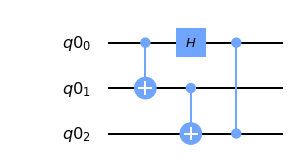

In [3]:
sub_q = QuantumRegister(3)
sub_circ = QuantumCircuit(sub_q, name='ent\nsw')

sub_circ.cx(sub_q[0], sub_q[1])
sub_circ.h(sub_q[0])
sub_circ.cx(sub_q[1], sub_q[2])
sub_circ.cz(sub_q[0], sub_q[2])

ent_swap = sub_circ.to_instruction()

sub_circ.draw(output='mpl')

# Preparing Quantum-Repeater Circuit

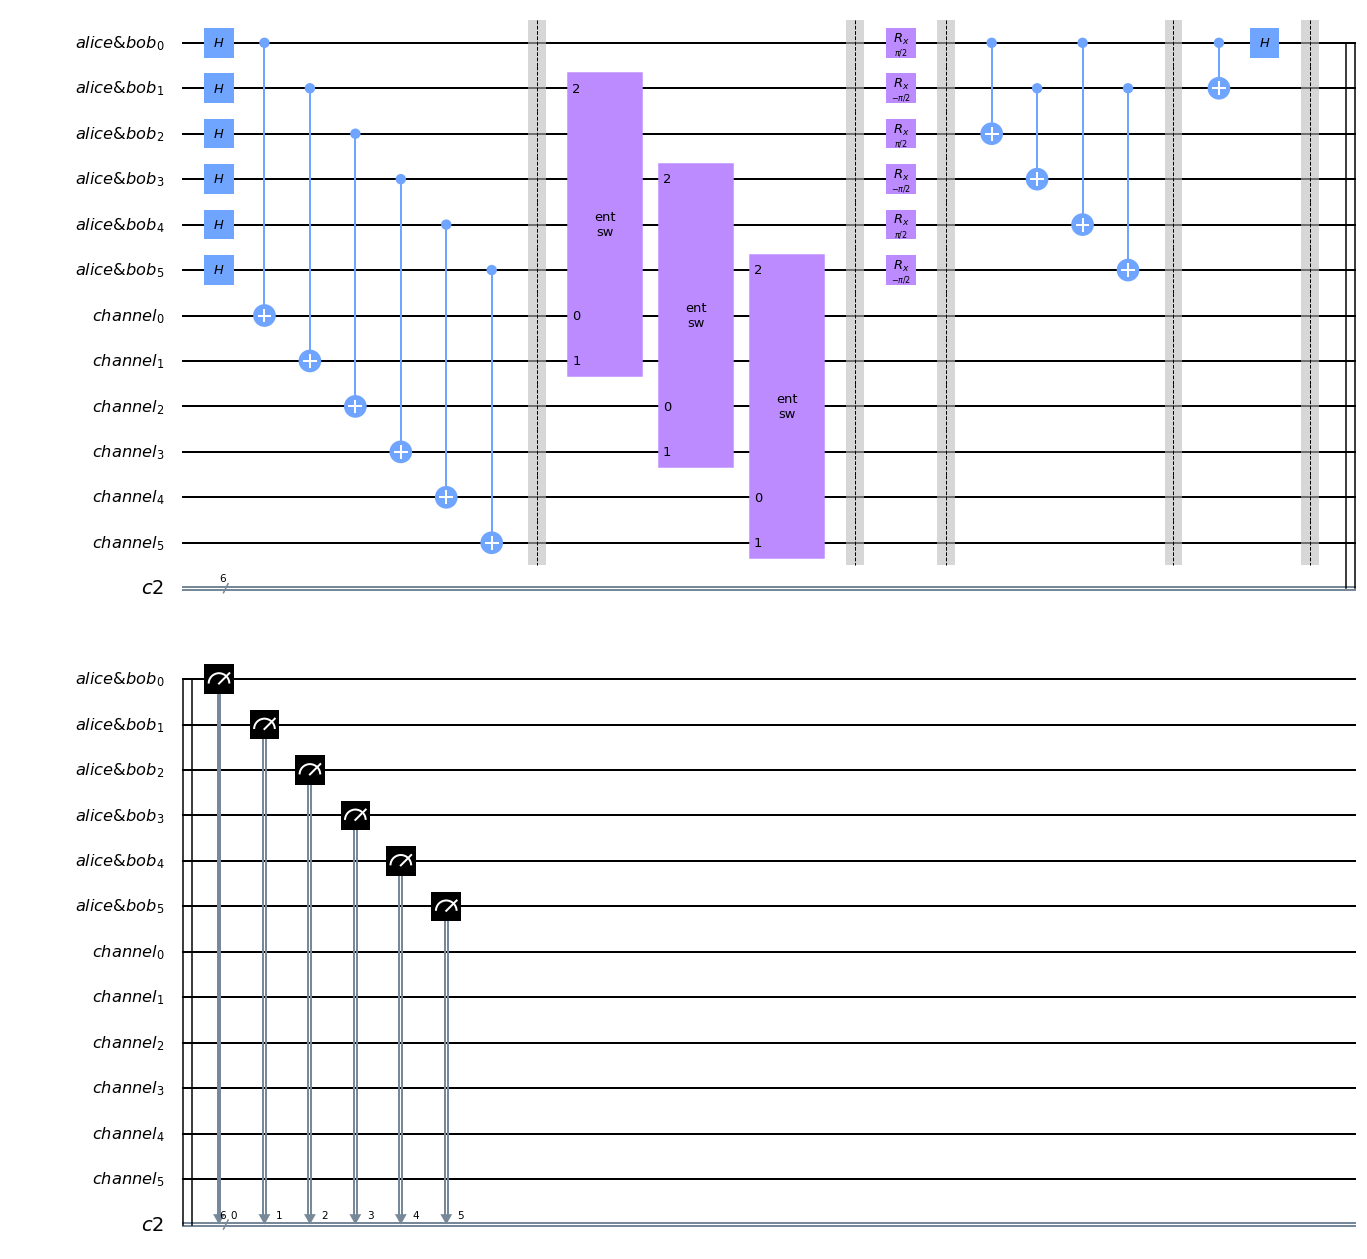

In [8]:
# preparing registers
users = QuantumRegister(6, 'alice & bob')
channel = QuantumRegister(6, 'channel')
checks = ClassicalRegister(6)

# constructing circuit

sys = QuantumCircuit(users, channel, checks)

# creating bell-pairs

for i in range(0, 6):
    sys.h(users[i])
    sys.cx(users[i], channel[i])

sys.barrier()

# entanglement swapping
for i in range(0, 6, 2):
    sys.append(ent_swap, [channel[i], channel[i+1], users[i+1]])

sys.barrier()

#Deutsch's Correction 

#rotation-Alice
for i in range(0, 6, 2):
    sys.rx(pi/2, users[i])
    sys.rx(-pi/2, users[i+1])

sys.barrier()

# Bennett's Protocol

for i in range(2, 6, 2):
    sys.cx(users[0], users[i])
    sys.cx(users[1], users[i+1])    
sys.barrier()

#checking fidelity through bell-measurement

sys.cx(users[0], users[1])
sys.h(users[0])
sys.barrier()

#distillation
sys.measure(users, checks)

sys.draw(output='mpl')

# Running on Real Device

In [5]:
job = execute(sys, 
              backend=device, shots=8192, optimization_level=0)

print(job.job_id())
job_monitor(job)

5ef22b99c745360013872e8c
Job Status: job has successfully run


In [6]:
device_result = job.result()
device_counts = device_result.get_counts()

print(device_counts)

metrics(device_counts)

{'1111': 385, '1100': 352, '0111': 590, '0010': 674, '1110': 374, '1011': 405, '0100': 600, '0101': 626, '1000': 415, '0011': 703, '0001': 611, '0000': 666, '1010': 401, '1001': 385, '1101': 355, '0110': 650}
success: 4120 , fail: 4072 , total: 8192
yield: 0.5029296875 

Among success, phi+: 1018 , psi+: 1048 , phi-: 966 , psi-: 1088
fidelity 0.2470873786407767


# Measurement Error Mitigation

## Generating Calibration Circuit and Filter

In [ ]:
#generating calibration circuits
cal_circuits, state_labels = complete_meas_cal(qr=sys.qregs[0],
                                               circlabel='measurement_calibration')

# running calibration circuits
cal_job = execute(cal_circuits, 
                  backend=device, shots=8192, optimization_level=0)

print(cal_job.job_id())
job_monitor(cal_job)

In [ ]:
cal_results = cal_job.result()

# creating mitigation filter
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_filter = meas_fitter.filter

## Mitigating Error

In [ ]:
# error mitigation
mitigated_result = meas_filter.apply(device_result)
mitigated_counts = mitigated_result.get_counts()

print(mitigated_counts)

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram([device_counts, mitigated_counts], 
               legend=['device, noisy', 'device, mitigated'])

In [ ]:
metrics(mitigated_counts)

In [ ]:
test_counts = {'011100': 142, '100100': 106, '101000': 127, '101100': 133, '011111': 103, '111110': 80, '101101': 105, '110001': 115, '111001': 144, '101001': 123, '010000': 196, '001101': 160, '111010': 114, '110010': 105, '110111': 78, '011001': 191, '110011': 88, '011010': 140, '100000': 137, '000011': 146, '001110': 126, '110100': 103, '001100': 152, '001011': 135, '101110': 96, '010111': 87, '101111': 88, '000001': 180, '001001': 167, '100011': 107, '101011': 151, '100001': 138, '100110': 89, '000100': 155, '001000': 191, '011110': 116, '001111': 117, '010100': 146, '010010': 137, '011011': 120, '010101': 137, '110000': 125, '110101': 69, '100101': 96, '111011': 100, '101010': 126, '111111': 76, '010110': 115, '000010': 180, '110110': 91, '000111': 126, '000000': 183, '001010': 166, '100010': 103, '011000': 165, '111100': 126, '000110': 143, '010011': 140, '100111': 113, '111101': 89, '011101': 139, '000101': 137, '010001': 171, '111000': 142}

In [ ]:
metrics(test_counts)

In [ ]:
test_miti = {'000010': 127.00054422870987, '001101': 156.6341941076184, '001100': 118.21682354643376, '001111': 118.45581617508257, '011101': 157.58888403724814, '100011': 101.58479242723554, '010011': 126.50340967973162, '100001': 142.493606544942, '011000': 118.87327959027672, '101100': 171.72727214412677, '110001': 130.27524955362904, '100000': 124.49732894560903, '011010': 118.21522895882347, '110111': 122.61224964678338, '011001': 178.0328428162, '000110': 115.99256738269685, '010110': 98.73450522288707, '000100': 109.87042369247821, '001000': 138.53614432604624, '111010': 152.17742197426136, '111000': 169.21375426533444, '000111': 101.99279690701799, '001011': 96.52992657434, '111111': 133.72580475154132, '011011': 107.21063220215339, '011110': 124.7657523102531, '101000': 120.07155918403677, '000101': 104.12421925772952, '001001': 127.57470242849942, '111011': 147.68551784779703, '101111': 133.80164673219343, '000011': 108.14931293580072, '010100': 121.91275158383557, '001110': 113.8287388308842, '101011': 210.65294127537743, '101101': 145.99639210400517, '001010': 127.69908570106018, '110010': 115.17842738735784, '111100': 195.31458557316097, '010111': 76.50687738397451, '100111': 156.85870551355694, '010001': 132.02276375595392, '100010': 88.43648157026429, '110100': 123.62944444194623, '100100': 106.32754592749042, '110101': 85.43020846449294, '011111': 121.26867473249047, '010000': 147.90436690363072, '000001': 117.11280014963219, '101001': 127.99099914809797, '101110': 128.13658936522373, '111110': 120.12207620390183, '100101': 107.98757201063007, '110000': 126.30274369444065, '010010': 97.23499748180807, '011100': 125.91882418840967, '101010': 144.04260932763765, '111101': 146.1120468054193, '111001': 209.62439546081717, '010101': 140.4758898313239, '110110': 127.29280121983199, '000000': 98.85525199098633, '100110': 95.86722156061579, '110011': 107.08698001422701}

In [ ]:
metrics(test_miti)